# Mel-Cepstral Distortion

This notebook will show you how to calculate the Mel-cepstral distortion (MCD) of target reference and converterted synthesised wavs that are not time aligned.

In [1]:
# import some stuff
import os
import math
import glob
import librosa
import pyworld
import pysptk
import numpy as np
import matplotlib.pyplot as plot

from binary_io import BinaryIOCollection

# 0 Functions and Constants

In [2]:
def load_wav(wav_file, sr):
    """
    Load a wav file with librosa.
    :param wav_file: path to wav file
    :param sr: sampling rate
    :return: audio time series numpy array
    """
    wav, _ = librosa.load(wav_file, sr=sr, mono=True)

    return wav


def log_spec_dB_dist(x, y):
    log_spec_dB_const = 10.0 / math.log(10.0) * math.sqrt(2.0)
    diff = x - y
    
    return log_spec_dB_const * math.sqrt(np.inner(diff, diff))


SAMPLING_RATE = 22050
FRAME_PERIOD = 5.0

# 1 The Data

The data used in this example is from the official website containing samples from the StarGAN-VC2 paper, which performs non-parallel multi-domain voice conversion with part of the Voice Conversion Challenge 2018 Corpora.

* MCD: 6.9 +- .08 dB for StarGAN-VC
* MCD: 6.9 +- .07 dB for StarGAN-VC2
* Link: http://www.kecl.ntt.co.jp/people/kaneko.takuhiro/projects/stargan-vc2/index.html

In [3]:
# Paths to target reference and converted synthesised wavs
stgan_vc_wav_paths = glob.glob('./data/official_stargan-vc/wavs/*')
stgan_vc2_wav_paths = glob.glob('./data/official_stargan-vc2/wavs/*')

stgan_vc2_wav_paths[:8]

['./data/official_stargan-vc2/wavs/conv',
 './data/official_stargan-vc2/wavs/trg']

## 1.1 Plot Spectograms

Taking a look at example `.wav` files, format is:

```
official_dir/wav/
    |
    |-<TRG_SPK_NAME>_<SAMPLE_ID>.wav
    |-...
    |-<TRG_SPK_NAME>_<ORG_SPK_NAME>_STARGANVC2_<SAMPLE_ID>.wav
    |-...
```

<class 'numpy.ndarray'>


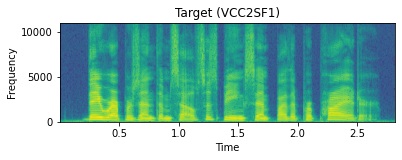

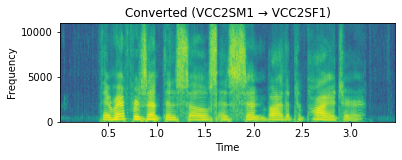

In [4]:
# Load the wavs
vc2_trg_ref = load_wav('./data/official_stargan-vc2/wavs/trg/VCC2SF1_30016.wav', sr=SAMPLING_RATE)
vc2_conv_synth = load_wav('./data/official_stargan-vc2/wavs/conv/VCC2SF1_VCC2SM1_STARGANVC2_30016.wav', sr=SAMPLING_RATE)

print(type(vc2_trg_ref))
    
plot.subplot(212)
plot.specgram(vc2_trg_ref, Fs=SAMPLING_RATE)
plot.title('Target (VCC2SF1)')
plot.xlabel('Time')
plot.ylabel('Frequency') 
plot.show()

plot.subplot(212)
plot.specgram(vc2_conv_synth, Fs=SAMPLING_RATE)
plot.title('Converted (VCC2SM1 → VCC2SF1)')
plot.xlabel('Time')
plot.ylabel('Frequency') 
plot.show()

# 2 Extract Acoustic Features

From the StarGAN-VC2 paper:

> Each speaker has sets of 81 and 35 sentences for training and evaluation, respectively. The recordings were downsampled to 22.05 kHz for this challenge. We extracted 34 Mel-cepstral coefficients (MCEPs), logarithmic fundamental frequency (log F0), and aperiodicities (APs) every 5 ms by using the WORLD analyzer [52].

Extract features using SPTK Mel-cepstral Analysis of speech (more info: http://sp-tk.sourceforge.net/)

This notebook uses python wrappers of the WORLD vocoder and SPTK to extract acoustic features:

* To get the spectral envelope: `pyworld` https://github.com/JeremyCCHsu/Python-Wrapper-for-World-Vocoder 
* To extract MCEP features: `pysptk` https://github.com/r9y9/pysptk  

In [5]:
def wav2mcep_numpy(wavfile, target_directory, alpha=0.65, fft_size=512, mcep_size=34):
    # make relevant directories
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)

    loaded_wav = load_wav(wavfile, sr=SAMPLING_RATE)

    # Use WORLD vocoder to spectral envelope
    _, sp, _ = pyworld.wav2world(loaded_wav.astype(np.double), fs=SAMPLING_RATE,
                                   frame_period=FRAME_PERIOD, fft_size=fft_size)

    # Extract MCEP features
    mgc = pysptk.sptk.mcep(sp, order=mcep_size, alpha=alpha, maxiter=0,
                           etype=1, eps=1.0E-8, min_det=0.0, itype=3)

    fname = os.path.basename(wavfile).split('.')[0]
    np.save(os.path.join(target_directory, fname + '.npy'),
            mgc,
            allow_pickle=False)


In [6]:
alpha = 0.65  # commonly used at 22050 Hz
fft_size = 512
mcep_size = 34

vc_trg_wavs = glob.glob('./data/official_stargan-vc/wavs/trg/*')
vc_trg_mcep_dir = './data/official_stargan-vc/mceps_numpy/trg'
vc_conv_wavs = glob.glob('./data/official_stargan-vc/wavs/conv/*')
vc_conv_mcep_dir = './data/official_stargan-vc/mceps_numpy/conv'

vc2_trg_wavs = glob.glob('./data/official_stargan-vc2/wavs/trg/*')
vc2_trg_mcep_dir = './data/official_stargan-vc2/mceps_numpy/trg'
vc2_conv_wavs = glob.glob('./data/official_stargan-vc2/wavs/conv/*')
vc2_conv_mcep_dir = './data/official_stargan-vc2/mceps_numpy/conv'

for wav in vc_trg_wavs:
    wav2mcep_numpy(wav, vc_trg_mcep_dir, fft_size=fft_size, mcep_size=mcep_size)

for wav in vc_conv_wavs:
    wav2mcep_numpy(wav, vc_conv_mcep_dir, fft_size=fft_size, mcep_size=mcep_size)

for wav in vc2_trg_wavs:
    wav2mcep_numpy(wav, vc2_trg_mcep_dir, fft_size=fft_size, mcep_size=mcep_size)

for wav in vc2_conv_wavs:
    wav2mcep_numpy(wav, vc2_conv_mcep_dir, fft_size=fft_size, mcep_size=mcep_size)


# 3 Calculate MCD

* Here I use librosa to calculate dynamic time warping (DTW) as it got a MCD score closer to that reported in the paper

In [7]:
def average_mcd(ref_mcep_files, synth_mcep_files, cost_function):
    """
    Calculate the average MCD.
    :param ref_mcep_files: list of strings, paths to MCEP target reference files
    :param synth_mcep_files: list of strings, paths to MCEP converted synthesised files
    :param cost_function: distance metric used
    :returns: average MCD, total frames processed
    """
    min_cost_tot = 0.0
    frames_tot = 0
    
    for ref in ref_mcep_files:
        for synth in synth_mcep_files:
            # get the trg_ref and conv_synth speaker name and sample id
            ref_fsplit, synth_fsplit = os.path.basename(ref).split('_'), os.path.basename(synth).split('_')
            ref_spk, ref_id = ref_fsplit[0], ref_fsplit[-1]
            synth_spk, synth_id = synth_fsplit[0], synth_fsplit[-1]
            
            # if the speaker name is the same and sample id is the same, do MCD
            if ref_spk == synth_spk and ref_id == synth_id:
                # load MCEP vectors
                ref_vec = np.load(ref)
                ref_frame_no = len(ref_vec)
                synth_vec = np.load(synth)

                # dynamic time warping using librosa
                min_cost, _ = librosa.sequence.dtw(ref_vec[:, 1:].T, synth_vec[:, 1:].T, 
                                                   metric=cost_function)
                
                min_cost_tot += np.mean(min_cost)
                frames_tot += ref_frame_no
                
    mean_mcd = min_cost_tot / frames_tot
    
    return mean_mcd, frames_tot

In [8]:
vc_trg_refs = glob.glob('./data/official_stargan-vc/mceps_numpy/trg/*')
vc_conv_synths = glob.glob('./data/official_stargan-vc/mceps_numpy/conv/*')
vc2_trg_refs = glob.glob('./data/official_stargan-vc2/mceps_numpy/trg/*')
vc2_conv_synths = glob.glob('./data/official_stargan-vc2/mceps_numpy/conv/*')

cost_function = log_spec_dB_dist

vc_mcd, vc_tot_frames_used = average_mcd(vc_trg_refs, vc_conv_synths, cost_function)
vc2_mcd, vc2_tot_frames_used = average_mcd(vc2_trg_refs, vc2_conv_synths, cost_function)


print(f'StarGAN-VC MCD = {vc_mcd} dB, calculated over a total of {vc_tot_frames_used} frames')
print(f'StarGAN-VC2 MCD = {vc2_mcd} dB, calculated over a total of {vc2_tot_frames_used} frames')

StarGAN-VC MCD = 7.174386035014262 dB, calculated over a total of 7262 frames
StarGAN-VC2 MCD = 6.391493428397028 dB, calculated over a total of 7262 frames
